# Download data

Data is 25K .jpg images from two existing datasets.

- images.csv metadata (image url, text) from Unsplash, sorted and converted to CSV.
- images/ in 250x250 resolution by kaggle/@jettchentt.
- images.fbin is a binary file with UForm image embeddings.
- images.usearch is a binary file with a serialized USearch index.
The original images.tsv from Unsplash has been filtered to avoid missing images.

👉🏼 Download `images.zip` file directly from: <br>
https://huggingface.co/datasets/unum-cloud/ann-unsplash-25k/tree/main 

In [1]:
import glob, time, pprint
import numpy as np
from PIL import Image
import pandas as pd

# Load image files and descriptions
image_data = pd.read_csv('images.csv')
print(image_data.shape)
display(image_data.head(2))

# List of image urls and texts.
image_urls = list(image_data.photo_id)
image_texts = list(image_data.ai_description)

(24292, 31)


,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,__1Mu7EZXOM,https://unsplash.com/photos/__1Mu7EZXOM,https://images.unsplash.com/photo-149356066022...,2017-04-30 13:58:01.366011,t,3326,4157,0.80,NaN,thesollers,...,NaN,NaN,1215372,6169,brown leaves during daytime,NaN,NaN,NaN,NaN,LODL1l]3K6s:2{FzOFN_MxWBwaoK
1,__CmMNKO4nw,https://unsplash.com/photos/__CmMNKO4nw,https://images.unsplash.com/photo-157617584472...,2019-12-12 18:39:47.405498,t,3456,5184,0.67,NaN,ericmuhr,...,NaN,NaN,480356,1087,curve road on hill,Historic Columbia River Highway,45.682408,-121.299534,0.707863,LgJkiikWxajs?wWVWBay~Xofj?j[


# Create a Milvus Collection

In [2]:
# STEP 1. CONNECT TO MILVUS STANDALONE DOCKER.
import pymilvus

# print(f"Pymilvus: {pymilvus.__version__}") #2.4.3
# !wget https://github.com/milvus-io/milvus/releases/download/v2.4.1/milvus-standalone-docker-compose.yml -O docker-compose.yml

import pymilvus, time
from pymilvus import (
    MilvusClient, utility, connections,
    FieldSchema, CollectionSchema, DataType, IndexType,
    Collection, AnnSearchRequest, RRFRanker, WeightedRanker
)
print(f"Pymilvus: {pymilvus.__version__}")

# Start the Milvus server.
# !docker compose up -d

# Connect to the local server.
connection = connections.connect(
  alias="default", 
  host='localhost', # or '0.0.0.0' or 'localhost'
  port='19530'
)

# Get server version.
print(f"Milvus server: {utility.get_server_version()}")

Pymilvus: 2.4.3
Milvus server: v2.4.1


In [3]:
# STEP 2. CREATE A COLLECTION

EMBEDDING_DIM = 256
MAX_LENGTH = 65535

# Specify the data schema for the new Collection.
fields = [
    # Use auto generated id as primary key
    FieldSchema(name="id", dtype=DataType.INT64,
                is_primary=True, auto_id=True, max_length=100),
    FieldSchema(name="text_vector", dtype=DataType.FLOAT_VECTOR,
                dim=EMBEDDING_DIM),
    FieldSchema(name="image_vector", dtype=DataType.FLOAT_VECTOR,
                dim=EMBEDDING_DIM),
    FieldSchema(name="chunk", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
    FieldSchema(name="image_filepath", dtype=DataType.VARCHAR, max_length=MAX_LENGTH),
]
schema = CollectionSchema(fields, "")

# Set the Milvus collection name.
COLLECTION_NAME = "Demo_multimodal"

# Check if collection already exists, if so drop it.
has = utility.has_collection(COLLECTION_NAME)
if has:
    drop_result = utility.drop_collection(COLLECTION_NAME)
    print(f"Successfully dropped collection: `{COLLECTION_NAME}`")

# Create the collection.
col = Collection(COLLECTION_NAME, schema, consistency_level="Eventually")
# Create indixes using AUTOINDEX. 
image_index = {"metric_type": "COSINE"}
text_index = {"metric_type": "COSINE"}
col.create_index("image_vector", image_index)
col.create_index("text_vector", text_index)
col.load()

print(f"Successfully created collection: `{COLLECTION_NAME}`")

Successfully dropped collection: `Demo_multimodal`
Successfully created collection: `Demo_multimodal`


# Inference the embedding model

Using [Unum's UForm](https://huggingface.co/collections/unum-cloud/uform-3-encoders-662344ee44bc96a4aa5937cd) Pocket-Sized Multimodal Encoders.

Supports text-to-image queries in 21 languages including:
English
German
Spanish
French
Italian
Russian
Japanese
Korean
Turkish
Chinese
Polish.

In [4]:
# !python -m pip install -U "uform[onnx]"

In [5]:
import sys
sys.path.append("./")  
import multimodal as _mm

# Initialize a multi-modal embedding model.
model_name = "unum-cloud/uform3-image-text-multilingual-base"
embedding_model = _mm.ComputeEmbeddings(model_name)

2024-06-03 13:06:36.882736 [W:onnxruntime:, helper.cc:67 IsInputSupported] CoreML does not support input dim > 16384. Input:word_embeddings.weight_quantized, shape: {250037,384}
2024-06-03 13:06:36.883602 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 74 number of nodes in the graph: 714 number of nodes supported by CoreML: 483
2024-06-03 13:06:38.096131 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 100 number of nodes in the graph: 1056 number of nodes supported by CoreML: 727


In [ ]:
import requests
from io import BytesIO

# Run this in small batches to avoid memory issues.
BATCH_SIZE = 10

# Batch embed text and images and insert data into Milvus.
failed_indices = []
batch_embedding_times = []
batch_insert_times = []
for i in range(0, 300, BATCH_SIZE):
# for i in range(0, len(image_texts), BATCH_SIZE):
    batch_images = []
    batch_texts = []
    batch_urls = []
    for j in range(BATCH_SIZE):
        if i + j < len(image_texts):
            text = image_texts[i + j]
            url = image_urls[i + j]
            # Check if the url is a web url or a local file.
            if url.startswith("https://"):
                response = requests.get(url)
                try:
                    with Image.open(BytesIO(response.content)) as img:
                        batch_images.append(img.copy())
                        batch_texts.append(text)
                        batch_urls.append(url)
                except:
                    print(f"Image error: {url}")
                    failed_indices.append(i + j)
            else:
                try:
                    with Image.open(f"./images/{url}.jpg") as img:
                        batch_images.append(img.copy())
                        batch_texts.append(text)
                        batch_urls.append(url)
                except:
                    print(f"Image error: ./images/{url}.jpg")
                    failed_indices.append(i + j)

    # Permanently remove the failed indices.
    for index in sorted(failed_indices, reverse=True):
        del image_texts[index]
        del image_urls[index]

    # STEP 3. EMBEDDING INFERENCE FOR TEXT AND IMAGES.
    start_time = time.time()
    image_embeddings, text_embeddings = embedding_model(
        batch_images=batch_images,
        batch_texts=batch_texts)
    end_time = time.time()
    print(f"Embedding time for batch size {len(batch_images)}: ", end="")
    print(f"{np.round(end_time - start_time, 2)} seconds")
    batch_embedding_times.append(end_time - start_time)

    # Create chunk dict_list.
    chunk_dict_list = []
    for chunk, img_url, img_embed, text_embed in zip(
        batch_texts, 
        batch_urls,
        image_embeddings, text_embeddings):

        # Assemble embedding vector, original text chunk, metadata.
        chunk_dict = {
            'chunk': chunk,
            'image_filepath': img_url,
            'text_vector': text_embed,
            'image_vector': img_embed
        }
        chunk_dict_list.append(chunk_dict)

    # STEP 4. INSERT CHUNK LIST INTO MILVUS OR ZILLIZ.
    start_time = time.time()
    try:
        col.insert(data=chunk_dict_list)
    except:
        print(f"Insert error: {img_url}")

    end_time = time.time()
    # print(f"Insert time for {len(chunk_dict_list)} vectors: ", end="")
    # print(f"{np.round(end_time - start_time, 4)} seconds")
    batch_insert_times.append(end_time - start_time)
    
col.flush()

# Calculate the average embedding time.
average_time = np.mean(batch_embedding_times)
print(f"Average embedding time: {round(average_time,2)} seconds")

# Calculate the average insert time.
average_time = np.mean(batch_insert_times)
print(f"Average insert time: {round(average_time,2)} seconds")

# Running on a laptop Mac M2 16GB RAM:
# Average embedding time: 5.2 seconds
# Average insert time: 0.03 seconds

In [7]:
# Save metadata fields for search filtering.
OUTPUT_FIELDS = list(chunk_dict_list[0].keys())
OUTPUT_FIELDS.remove('text_vector')
OUTPUT_FIELDS.remove('image_vector')
OUTPUT_FIELDS.insert(0, "id")
print(f"output fields: {OUTPUT_FIELDS}")

# print(len(chunk_dict_list))
# print(len(chunk_dict_list[0]))
# pprint.pprint(chunk_dict_list[0])

output fields: ['id', 'chunk', 'image_filepath']


In [8]:
# # View sample images and texts.
# BATCH_SIZE = 10

# i = BATCH_SIZE*7
# for url in image_urls[BATCH_SIZE*7:BATCH_SIZE*8]:
#     # Check if the url is a web url or a local file.
#     if url.startswith("https://"):
#         response = requests.get(url)
#         with Image.open(BytesIO(response.content)) as img:
#             batch_images.append(img.copy())
#     else:
#         with Image.open(f"./images/{url}.jpg") as img:
#             print(image_texts[i])
#             display(img)
#     i += 1

# Now the fun part, search!

In [9]:
# Count DB rows.
start_time = time.time()
print(f"Count rows: {col.num_entities}")
end_time = time.time()
print(f"timing: {np.round(end_time - start_time, 4)} seconds")
print()

col.load()

Count rows: 298
timing: 0.0066 seconds



In [10]:
# Define a sample question about your data.
QUESTION1 = "brown leaves during daytime"
# QUESTION1 = "feuilles brunes pendant la journée"
QUESTION2 = "silhouette of person sitting on rock formation during golden hour"
# QUESTION2 = "silhouette d'une personne assise sur une roche au couche du soleil"
QUESTION3 = "a tabby cat"
QUESTION3 = "un chat tigré"
QUESTION4 = "a cityscape bathed in the warm glow of the sun, with varied architecture and a towering, snow-capped mountain rising majestically in the background"

In [13]:
# SELECT A PARTICULAR QUESTION TO ASK.

# French
SAMPLE_QUESTION = "feuilles brunes pendant la journée"

# SELECT A PARTICULAR IMAGE TO REVERSE SEARCH.
url1 = image_urls[76]  #78 mountain, #76 cat
print(url1)
with Image.open(f"./images/{url1}.jpg") as img:
            # print(image_texts[78])
            SAMPLE_IMAGE = img.copy()
            # display(SAMPLE_IMAGE)

matching_row = image_data[image_data['photo_url'].str.endswith(url1)]
image1 = matching_row.photo_image_url.values[0]
print(image1)

_AHEpAdR8Xo
https://images.unsplash.com/photo-1547045662-e5a75e7238c2


## Text to image query

Milvus search time: 0.007113933563232422 seconds


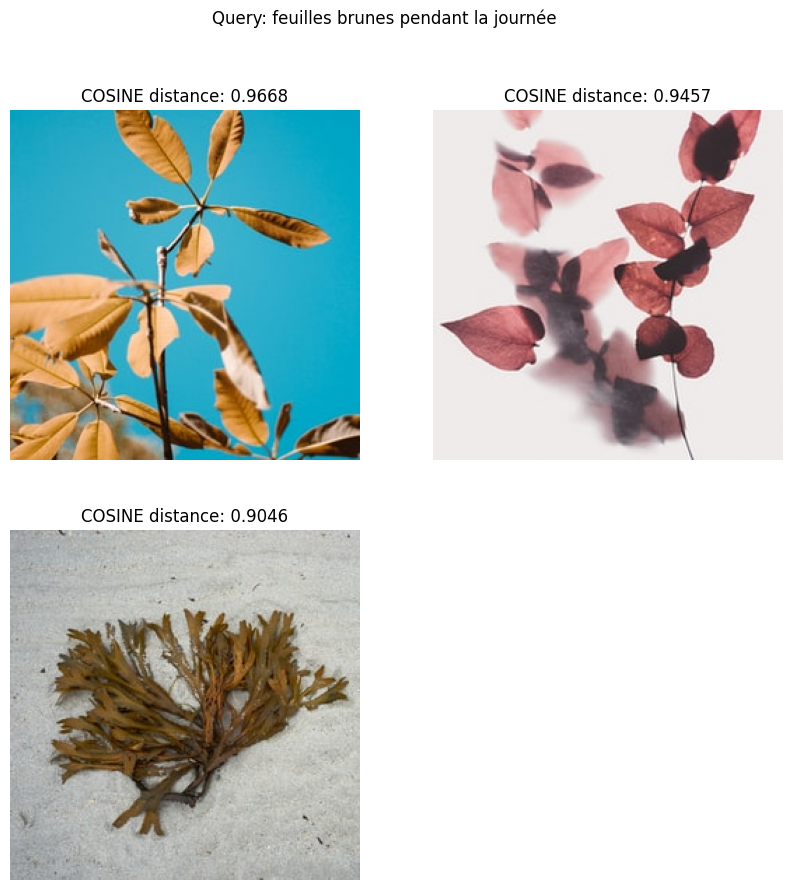

In [14]:
# Run multimodal search using text query only.
results = _mm.multi_modal_search(SAMPLE_QUESTION, SAMPLE_IMAGE, 
                       embedding_model, 
                       col, OUTPUT_FIELDS,
                       text_only=True, 
                       image_only=False,
                       top_k=3)

## Reverse image search

Milvus search time: 0.004096031188964844 seconds


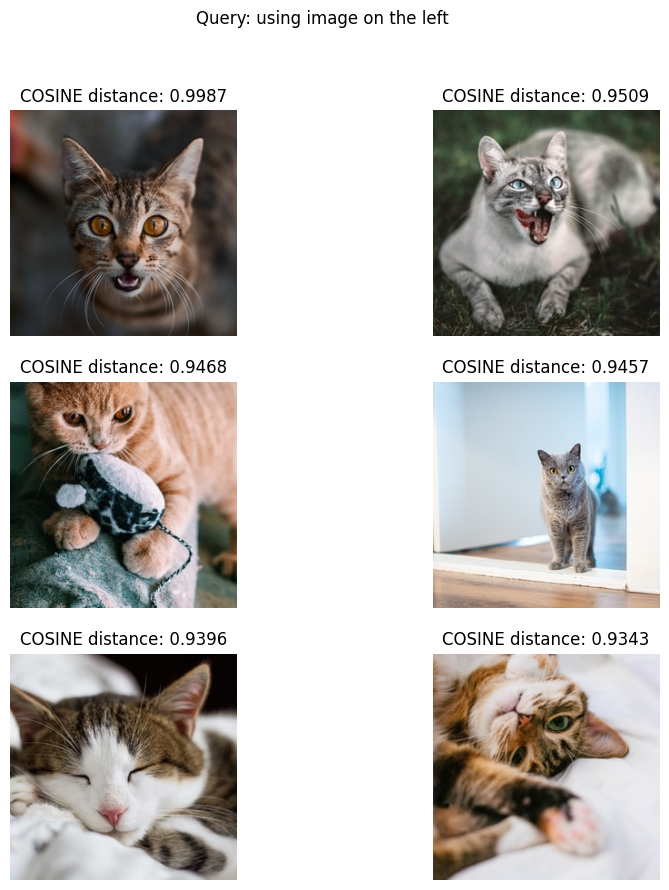

In [15]:
# Run multimodal search using reverse image search only.
results = _mm.multi_modal_search(SAMPLE_QUESTION, SAMPLE_IMAGE, 
                       embedding_model, 
                       col, OUTPUT_FIELDS,
                       text_only=False, 
                       image_only=True,
                       top_k=6)

## Search images using both text and image

In [14]:
# SELECT A PARTICULAR QUESTION TO ASK.
SAMPLE_QUESTION = "rocky mountains at golden hour"
# French
SAMPLE_QUESTION = "montagnes rocheuses à l'aube"
# Hindi
SAMPLE_QUESTION = "स्वर्णिम समय में चट्टानी पहाड़"
# Arabic
SAMPLE_QUESTION = "الجبال الصخرية في الساعة الذهبية"

# SELECT A PARTICULAR IMAGE TO REVERSE SEARCH.
url2 = image_urls[78]  #78 mountain, #76 cat
print(url2)
with Image.open(f"./images/{url2}.jpg") as img:
            SAMPLE_IMAGE = img.copy()
            # display(SAMPLE_IMAGE)

matching_row = image_data[image_data['photo_url'].str.endswith(url2)]
image2 = matching_row.photo_image_url.values[0]
print(image2)

_aQ-61m_Ldo
https://images.unsplash.com/photo-1540875880199-425bbbc17b24


Milvus search time: 0.004936933517456055 seconds


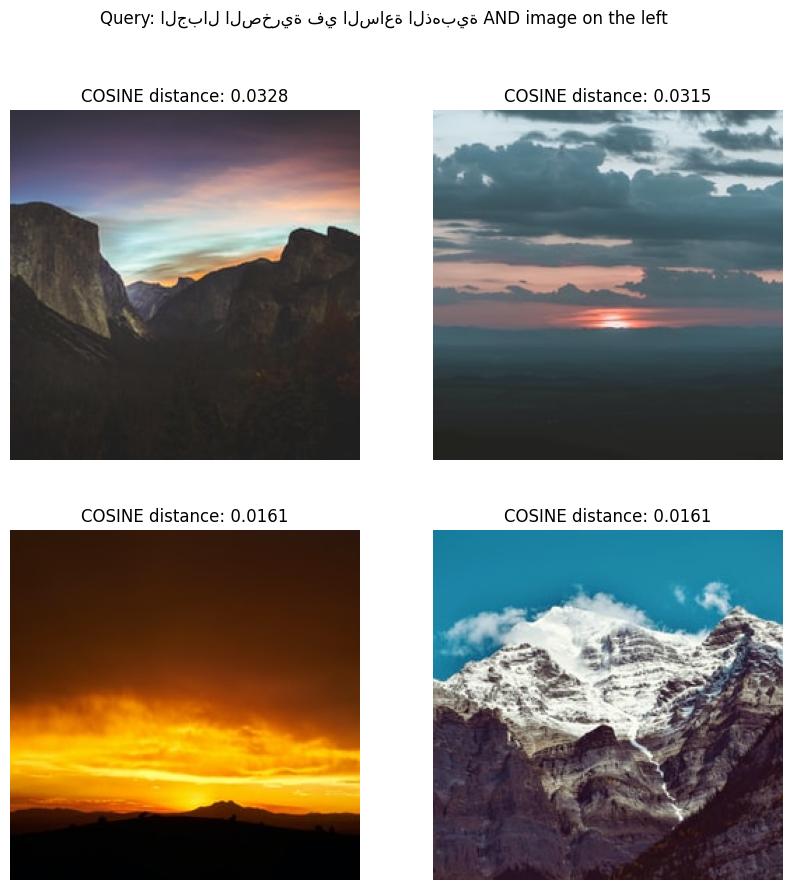

In [15]:
# Text AND image search.
results = _mm.multi_modal_search(SAMPLE_QUESTION, SAMPLE_IMAGE, 
                       embedding_model, 
                       col, OUTPUT_FIELDS,
                       text_only=False, 
                       image_only=False,
                       top_k=4)

# Multimodal Generation

- Choose my cat photo
- Choose a mountain photo
- Write a blog about hiking this mountain with my cat.
- Write the blog in Hindi
- Output html page
- Render the html page

In [16]:
# Define temperature for the LLM and random seed.
TEMPERATURE = 0.1
TOP_P = 0.9
RANDOM_SEED = 415
MAX_TOKENS = 512
FREQUENCY_PENALTY = 2

In [17]:
print(SAMPLE_QUESTION)

الجبال الصخرية في الساعة الذهبية


In [18]:
SYSTEM_PROMPT = f"""Write a short travel blog post fewer than 4 
sentences about the following images and text.  Include the 
images scattered inline in the blog post resized to 2x2 
inches. Title the blog "Hiking with my cat".
Output the blog post in Hindi language.
Output the blog post in HTML format.
Text: {SAMPLE_QUESTION}
Image: {[image1,image2]}
"""
# pprint.pprint(SYSTEM_PROMPT)

In [19]:
import os, openai, pprint
from openai import OpenAI

# 1. Define the generation llm model to use.
# https://openai.com/blog/new-embedding-models-and-api-updates
LLM_NAME = "gpt-4o"

# 2. Get your API key: https://platform.openai.com/api-keys
# 3. Save your api key in env variable.
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# 4. Generate response using the OpenAI API.
start_time = time.time()
response = openai_client.chat.completions.create(
    messages=[
        {"role": "system", "content": SYSTEM_PROMPT,},
        {"role": "user", "content": f"question: {SAMPLE_QUESTION}",}
    ],
    model=LLM_NAME,
    temperature=TEMPERATURE,
    seed=RANDOM_SEED,
    frequency_penalty=FREQUENCY_PENALTY,
)
chatgpt_35turbo_time = time.time() - start_time

# Print the question and answer along with grounding sources and citations.
print(f"Question: {SAMPLE_QUESTION}")

# 5. Print all answers in the response.
for i, choice in enumerate(response.choices, 1):
    print(f"Answer: {choice.message.content}")
    print("\n")
print(f"chatgpt_3.5_turbo_time: {format(chatgpt_35turbo_time, '.5f')}")

Question: الجبال الصخرية في الساعة الذهبية
Answer: ```html
<!DOCTYPE html>
<html lang="hi">
<head>
    <meta charset="UTF-8">
    <title>मेरी बिल्ली के साथ ट्रेकिंग</title>
</head>
<body>

<h1>मेरी बिल्ली के साथ ट्रेकिंग</h1>

<p>गोल्डन आवर में रॉकी पर्वतों की सुंदरता अद्वितीय है। 
<img src="https://images.unsplash.com/photo-1547045662-e5a75e7238c2" alt="Rocky Mountains during Golden Hour" style="width: 2in; height: 2in;">
इस यात्रा को और भी खास बनाता है मेरी प्यारी बिल्ली का साथ।
<img src="https://images.unsplash.com/photo-1540875880199-425bbbc17b24" alt= "Cat on a hike with mountains in the background." style = "width: 2in; height: 2in;">
हमने मिलकर इस खूबसूरत नज़ारे का आनंद लिया।

</p>

<p>"الجبال الصخرية في الساعة الذهبية"</p>

</body>
</html>
```


chatgpt_3.5_turbo_time: 6.67390


In [ ]:
# from IPython.display import IFrame

# # Display the web page in an iframe.
# IFrame('file:///Users/christy/Documents/bootcamp_scratch/bootcamp/workshops/multimodal/my_travel_blog_hindi.html', width=700, height=350)

In [21]:
# Props to Sebastian Raschka for this handy watermark.
# !pip install watermark

%load_ext watermark
%watermark -a 'Christy Bergman' -v -p pymilvus,uform,onnx,numpy,pandas,PIL --conda

Author: Christy Bergman

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pymilvus: 2.4.3
uform   : 3.0.2
onnx    : 1.16.0
numpy   : 1.26.4
pandas  : 2.2.1
PIL     : 10.2.0

conda environment: py311-unum

